# DS6050
## Assignment 1
## Dominic Scerbo (yt7qf)

In [19]:
from __future__ import print_function

from builtins import range
from builtins import object
import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange

class TwoLayerNeuralNetwork(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # First layer (input to hidden)
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1) # Using ReLU activation

        # Second layer (hidden to output)
        z2 = a1.dot(W2) + b2
        a2 = z2

        # Contains class scores for each input sample
        # Shape is (N, num_classes)
        scores = a2

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Calculate the data loss (Softmax loss)
        exp_scores = np.exp(scores)
        a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        correct_log_probs = -np.log(a2[range(N), y])
        data_loss = np.sum(correct_log_probs) / N

        # Calculate the L2 regularization loss
        reg_loss = reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

        # Total loss is the sum of data loss and regularization loss
        loss = data_loss + reg_loss

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Hint: Hidden -> Output layer gradients
        # Checks:
        # print(scores_normalised.shape)
        # print(Z.shape)
        # Hint: Input -> Hidden layer gradients

        dscores = a2
        dscores[range(N), y] -= 1
        dscores /= N

        # Gradient of the hidden layer weights (W2) and biases (b2)
        dW2 = np.dot(a1.T, dscores)
        db2 = np.sum(dscores, axis=0)

        # Backpropagate gradient (ReLU activation)
        dhidden = np.dot(dscores, W2.T)
        dhidden[z1 <= 0] = 0

        # Gradient of the first layer weights (W1) and biases (b1)
        dW1 = np.dot(X.T, dhidden)
        db1 = np.sum(dhidden, axis=0)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        dW2 += 2*W2*reg
        dW1 += 2*W1*reg

        # Update the gradients
        grads['W2'] = dW2
        grads['b2'] = db2
        grads['W1'] = dW1
        grads['b1'] = db1

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            batch_ix = np.random.choice(num_train, batch_size)
            X_batch = X[batch_ix]
            y_batch = y[batch_ix]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            ###########################################################################
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Loop over parameters of the network
            for w in self.params:
                # Update parameter "w" from grad dict using SGD
                self.params[w] -= grads[w].reshape(self.params[w].shape) * learning_rate

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            ###########################################################################
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Compute the loss and gradients for the neural network
        scores = self.loss(X)
        y_pred = np.argmax(scores, axis=1)

        #Checks:
        #print("Y pred shape :"+str(y_pred.shape))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        return y_pred

In [20]:
### HELPER FUNCTIONS: DO NOT MODIFY ###
from __future__ import print_function
from builtins import range
from past.builtins import xrange
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.

    We assume that f accepts several input blobs as arguments, followed by a
    blob where outputs will be written. For example, f might be called like:

    f(x, w, out)

    where x and w are input Blobs, and the result of f will be written to out.

    Inputs:
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              %(grad_numerical, grad_analytic, rel_error))


import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Implementing a Neural Network

In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.


We will use the class TwoLayerNet object to represent instances of our network. The network parameters are stored in the instance variable self.params where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [21]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_sample_model():
    np.random.seed(0)
    return TwoLayerNeuralNetwork(input_size, hidden_size, num_classes, std=1e-1)

def generate_sample_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

myNeuralNetwork = init_sample_model()
X, y = generate_sample_data()

## Forward pass: compute scores

The method TwoLayerNet.loss is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [22]:
scores = myNeuralNetwork.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


## Forward pass: compute loss

In the same function, implement the second part that computes the data and regularization loss.

In [27]:
loss, _ = myNeuralNetwork.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


## Backward pass

Implement the rest of the function. This will compute the gradient of the loss with respect to the variables W1, b1, W2, and b2. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [28]:
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = myNeuralNetwork.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: myNeuralNetwork.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, myNeuralNetwork.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


## Train the network

To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function TwoLayerNet.train and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement TwoLayerNet.predict, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

Final training loss:  0.017149607938732048


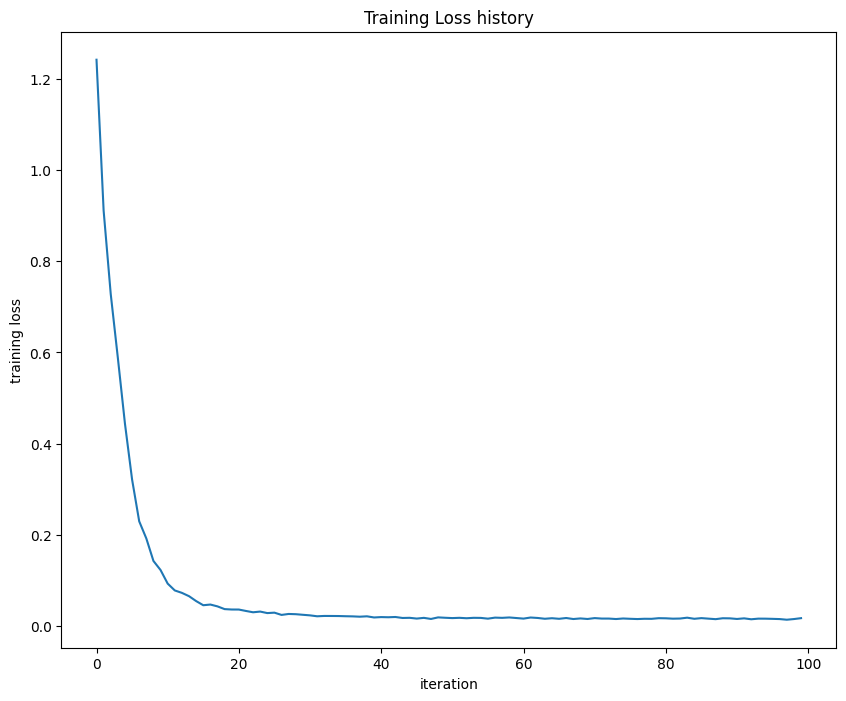

In [29]:
myNeuralNetwork = init_sample_model()
stats = myNeuralNetwork.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


## Load the data

Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [31]:
pip install cifar10

In [32]:
# pip install cifar10
def load_CIFAR10():
  import cifar10
  import numpy as np
  from sklearn.model_selection import train_test_split

  images = []
  labels = []
  for image, label in cifar10.data_batch_generator():
      images.append(image.astype('float32')) # numpy array of an image, which is of shape 32 x 32 x 3
      labels.append(label) # integer value of the image label

  images = np.array(images)
  labels = np.array(labels)

  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

  return X_train, X_test, y_train, y_test


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, X_test, y_train, y_test = load_CIFAR10()

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

cifar-10-python.tar.gz: 170MB [00:05, 28.8MB/s]                           


Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Train a network

To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [42]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
network = TwoLayerNeuralNetwork(input_size, hidden_size, num_classes)

# Train the network
stats = network.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (network.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302970
iteration 100 / 1000: loss 2.302502
iteration 200 / 1000: loss 2.297582
iteration 300 / 1000: loss 2.256385
iteration 400 / 1000: loss 2.207505
iteration 500 / 1000: loss 2.091202
iteration 600 / 1000: loss 2.108200
iteration 700 / 1000: loss 2.094242
iteration 800 / 1000: loss 2.071780
iteration 900 / 1000: loss 1.999826
Validation accuracy:  0.298


## Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

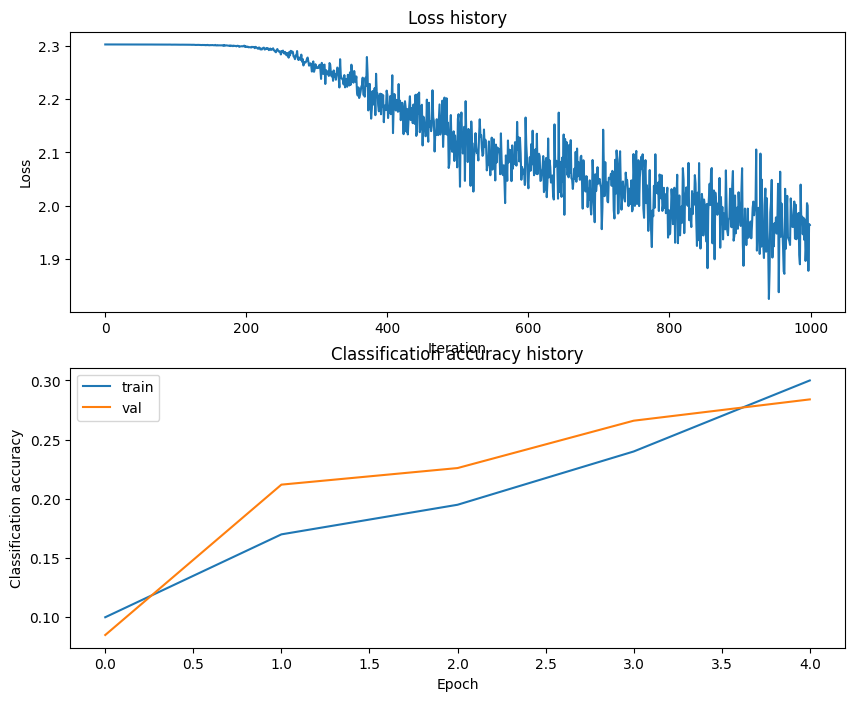

In [34]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

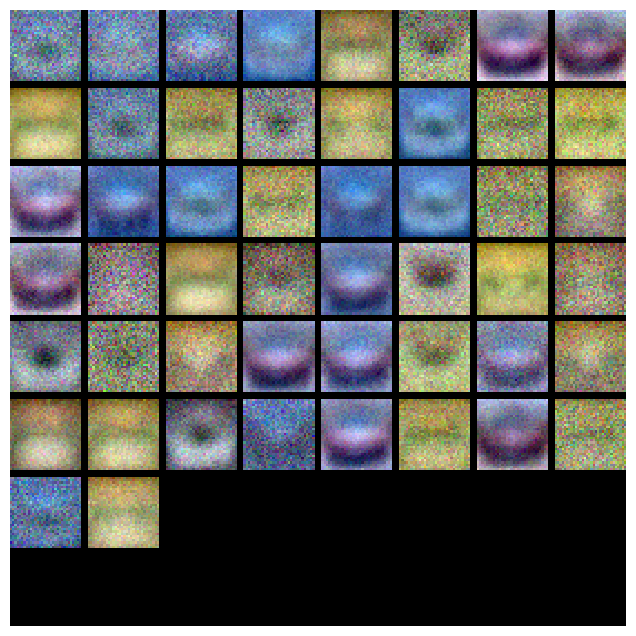

In [35]:
# Visualize the weights of the network
from math import sqrt, ceil
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(network)

## BONUS POINT: Tune your hyperparameters
What's wrong?. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

Tuning. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

Approximate results. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

Experiment: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

Explain your hyperparameter tuning process below.

 Answer: Tuning multiple parameters that can have variable values by trying different combinations and obtaining the best model that fits the data.

In [36]:
best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from tqdm.notebook import tqdm
import itertools

# Const Params
input_size = 32 * 32 * 3
num_classes = 10
iters = 2000

# Variable Params
learning_rates = [1e-2, 1e-3, 1e-4]
learning_rate_decays = [0.95]
regularization_strengths = [1e-1, 1e-2, 1e-3, 1e-4]
batch_sizes = [128, 256, 512]
hidden_sizes = [80, 160, 320]

params = [learning_rates, learning_rate_decays, regularization_strengths, batch_sizes, hidden_sizes]
param_combinations = list(itertools.product(*params))

# Track best metrics
best_accuracy_val = -999999
best_stats = None

# Loop over all combinations
for lr, lrd, rs, bs, hs in tqdm(param_combinations):

    net = TwoLayerNeuralNetwork(input_size, hs, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val,
                      num_iters=iters, batch_size=bs,
                      learning_rate=lr, learning_rate_decay=lrd,
                      reg=rs)

    y_train_pred = net.predict(X_train)
    accuracy_train = np.mean(y_train == y_train_pred)

    y_val_pred = net.predict(X_val)
    accuracy_val = np.mean(y_val == y_val_pred)

    if best_accuracy_val < accuracy_val:
        best_net = net
        best_accuracy_val = accuracy_val
        best_stats = stats
        print(f"Current Best Validation Accuracy: {best_accuracy_val}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  0%|          | 0/108 [00:00<?, ?it/s]

<ipython-input-19-044131982891>:112: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
<ipython-input-19-044131982891>:113: RuntimeWarning: invalid value encountered in divide
  a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
<ipython-input-19-044131982891>:114: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(a2[range(N), y])


Current Best Validation Accuracy: 0.108
Current Best Validation Accuracy: 0.542
Current Best Validation Accuracy: 0.567
Current Best Validation Accuracy: 0.569
Current Best Validation Accuracy: 0.599
Current Best Validation Accuracy: 0.603
Current Best Validation Accuracy: 0.616
Current Best Validation Accuracy: 0.621


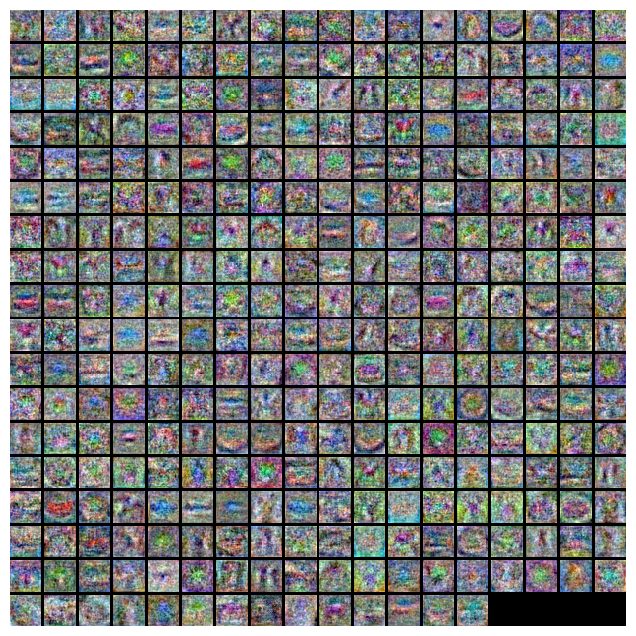

In [37]:
# Visualize the weights of the best network
show_net_weights(best_net)

## Run on the test set

When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [38]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.604


## Visualize Best Stats

Text(0, 0.5, 'Loss')

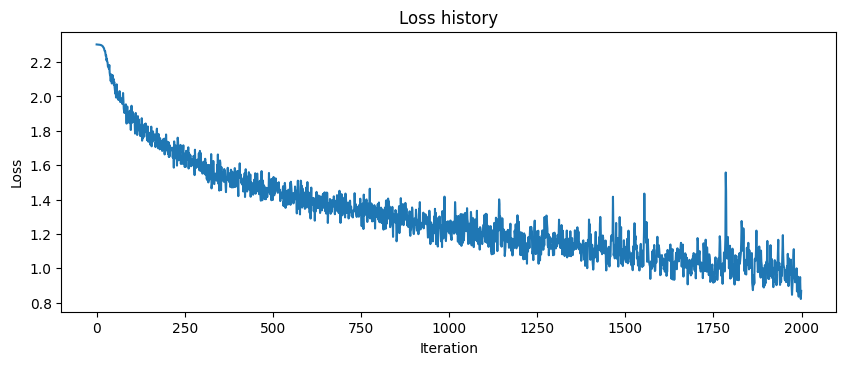

In [44]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# plt.subplot(2, 1, 2)
# plt.plot(best_stats['train_acc_history'], label='train')
# plt.plot(best_stats['val_acc_history'], label='val')
# plt.title('Classification accuracy history')
# plt.xlabel('Epoch')
# plt.ylabel('Classification accuracy')
# plt.legend()
# plt.show()

### Inline Question

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.


## Answer
1) Train on a larger dataset. Yes, increasing the size of the dataset can help the model generalize better
3) Increase the regularization strength. Yes, this can help reduce overfitting by penalizing large weights in the network thus preventing the model from picking up noise and allowing it to generalize better.

Note 2 is not necessarily helpful because it may cause the model to further overfit.